<a href="https://colab.research.google.com/github/Keenandrea/ULMFiT/blob/master/ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ULMFiT: But What Does It Do?

---
Universal Language Model Fine-Tuning for Text Classification, or, ULMFiT, in Layman's terms, is a method that opens the door of Transfer Learning to NLP. 

ULMFiT fine-tunes a pre-trained language model to a new dataset using a technique that does not allow the model to forget what it previously learned. 

Language modeling boxes general properties of a language into enormous amounts of data which can then be plugged into downstream NLP tasks. Here is a link to the original [ULMFiT](https://arxiv.org/abs/1801.06146) paper.

---

## but what are we going to do?

---

We're going to fine-tune a pre-trained model, then use it for text classification on a new dataset. Our new dataset will be small, less than one-thousand labeled instances. Let's hit it.

# Importing Dependencies

---

If you haven't heard of stacking [PyTorch](https://pytorch.org/) and [fastai](https://www.fast.ai/) for models, you should click the links. Our environment will be using both.

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Then we'll download other popular libraries along with PyTorch and fastai:

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

And then we'll import the less-than-one-thousand-labeled-instances-new-dataset we spoke of earlier. Here's a link to the dataset: [ sklearn.datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html#sklearn.datasets.fetch_20newsgroups).

In [0]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [0]:
dataset.target_names

We'll create a [ pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html), a tabular data structure with labeled axes, which, in our case, will be text documents and their corresponding newsgroup names:

In [0]:
df = pd.DataFrame({'label':dataset.target,
                   'text':dataset.data})

In [6]:
df.shape

(11314, 2)

Next we convert this into a [ binary classification](https://www.sciencedirect.com/topics/computer-science/binary-classification) problem, which considers assigning some element into one of two categories, by measuring a series of attributes.

Our instance selects two out of the twenty labels present in the dataset. The two labels we will select will be labels- one and ten, which are *comp.graphics* and *rec.sport.hockey*.

In [0]:
df = df[df['label'].isin([1,10])]
df = df.reset_index(drop = True)

Looking at the target distribution, we can see that *comp.graphics* and *rec.sport.hockey* exhibit a fairly even distribution. That is good. That makes accuracy a good evaluation metric to use in our case.

In [8]:
df['label'].value_counts()

10    600
1     584
Name: label, dtype: int64

# Preprocessing Stage

---

What matters almost most of a clean model is feeding it clean data, especially in NLP. 

We start off cleaning our data by retaining only alphabetical characters:

In [0]:
df['text'] = df['text'].str.replace("[^a-zA-Z]", " ")

Then we remove the stopwords:

In [0]:
import nltk
nltk.download('stopwords')

In [0]:
from nltk.corpus import stopwords 
stop_words = stopwords.words('english')

Next phase, tokenization:

In [0]:
tokenized_doc = df['text'].apply(lambda x: x.split())

# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words]) 

# de-tokenization 
detokenized_doc = [] 
for i in range(len(df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
df['text'] = detokenized_doc

And finally, we split our cleaned dataset into training and validation sets by a 60:40 split:

In [0]:
from sklearn.model_selection import train_test_split

# split data into training and validation set
df_trn, df_val = train_test_split(df, stratify = df['label'], test_size = 0.4, random_state = 12)

In [16]:
df_trn.shape, df_val.shape

((710, 2), (474, 2))

# Preparing Data

---

Here we'll use the fastai library to prepare our data for the language model, and prepare our data for the classification model:

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In the following cell we fine-tune the pre-trained language model using the *data_lm* object we created earlier.

Out of this, we create a learner object *learn*, which directly creates a model, downloads the pre-trained weights, and readies itself for fine-tuning:

In [0]:

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.7)

What is *fit_one_cycle* and why the heck are we implementing it?

Well, one cycle and cyclic momentum allow the model to be trained at higher learning rates while also converging faster.

One cycle also provides a model with some form of regularization. Learn more about it [here](https://arxiv.org/abs/1803.09820).  

In [22]:
# train the learner object
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,6.669874,5.539165,0.232063,00:05


In [23]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


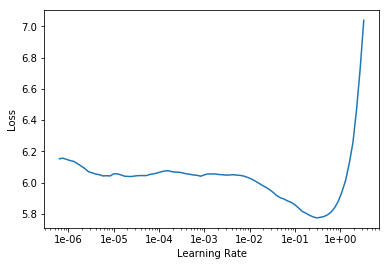

In [24]:
learn.recorder.plot()

We save this encoder so we can use it for classification:

In [0]:
learn.save_encoder('ft_enc')

Then we'll use the *data_clas* object we created earlier to build a classifier with our fine-tuned encoder:

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.7)
learn.load_encoder('ft_enc')

Again, we'll fit and plot our model:

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


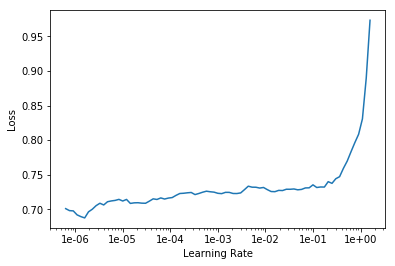

In [31]:
learn.lr_find()
learn.recorder.plot()

In [27]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.767837,5.115008,0.261049,00:05


Talk about a fine howdy-doo. We've experienced a meteoric increase in the accuracy, plus the validation loss is far less than the training loss. Considering how small our dataset was, it's pretty darn outstanding what ULMFiT has accomplished. One last thing: if you'd like to get the predictions for the validation set out of the learner object, use the code below:

In [33]:
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1
row_0,,
1,234,240


## the end.